<a href="https://www.kaggle.com/code/atifmasih/rainfall-predictions-on-pakistan-dataset-lstm?scriptVersionId=191402448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wfp-rainfall-indicators-pakistan-1981-2024/Rain_fall_in_Pakistan.csv


**import all libraries**

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

2024-08-06 11:40:35.760264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 11:40:35.760391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 11:40:35.913319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/wfp-rainfall-indicators-pakistan-1981-2024/Rain_fall_in_Pakistan.csv", parse_dates=['date'])
df.head(3)

/tmp/ipykernel_19/1269954650.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/kaggle/input/wfp-rainfall-indicators-pakistan-1981-2024/Rain_fall_in_Pakistan.csv", parse_dates=['date'])


,date,adm2_id,ADM2_PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,#date,#adm2+id,#adm2+code,#indicator+n_pixels+num,#indicator+rfh+num,#indicator+rfh_avg+num,#indicator+r1h+num,#indicator+r1h_avg+num,#indicator+r3h+num,#indicator+r3h_avg+num,#indicator+rfq+pct,#indicator+r1q+pct,#indicator+r3q+pct,#status
1,1981-01-01,1009036,PK401,36.0,33.9444,20.9926,NaN,NaN,NaN,NaN,149.829,NaN,NaN,final
2,1981-01-11,1009036,PK401,36.0,7.9167,21.4537,NaN,NaN,NaN,NaN,48.8274,NaN,NaN,final


**Explore dataset**

In [4]:
df.shape

(47071, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47071 entries, 0 to 47070
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        47071 non-null  object
 1   adm2_id     47071 non-null  object
 2   ADM2_PCODE  47071 non-null  object
 3   n_pixels    47071 non-null  object
 4   rfh         47071 non-null  object
 5   rfh_avg     47071 non-null  object
 6   r1h         47011 non-null  object
 7   r1h_avg     47011 non-null  object
 8   r3h         46831 non-null  object
 9   r3h_avg     46831 non-null  object
 10  rfq         47071 non-null  object
 11  r1q         47011 non-null  object
 12  r3q         46831 non-null  object
 13  version     47071 non-null  object
dtypes: object(14)
memory usage: 5.0+ MB


In [6]:
print(df.dtypes)

date          object
adm2_id       object
ADM2_PCODE    object
n_pixels      object
rfh           object
rfh_avg       object
r1h           object
r1h_avg       object
r3h           object
r3h_avg       object
rfq           object
r1q           object
r3q           object
version       object
dtype: object


In [7]:
numeric_cols = ['rfh', 'rfh_avg', 'r1h', 'r1h_avg', 'r3h', 'r3h_avg', 'rfq', 'r1q', 'r3q']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')  # Ensure numeric type

**Fill missing values**

In [8]:
df.isnull().sum()

date            0
adm2_id         0
ADM2_PCODE      0
n_pixels        0
rfh             1
rfh_avg         1
r1h            61
r1h_avg        61
r3h           241
r3h_avg       241
rfq             1
r1q            61
r3q           241
version         0
dtype: int64

In [9]:

# Fill missing values
imputer = SimpleImputer(strategy='mean')
df[['rfh','rfh_avg','r1h', 'r1h_avg', 'r3h', 'r3h_avg','rfh_avg','rfq', 'r1q', 'r3q']] = imputer.fit_transform(
    df[['rfh','rfh_avg','r1h', 'r1h_avg', 'r3h', 'r3h_avg','rfh_avg','rfq', 'r1q', 'r3q']]
)


In [10]:
df.isnull().sum()

date          0
adm2_id       0
ADM2_PCODE    0
n_pixels      0
rfh           0
rfh_avg       0
r1h           0
r1h_avg       0
r3h           0
r3h_avg       0
rfq           0
r1q           0
r3q           0
version       0
dtype: int64

**Normalize the features**

In [11]:
# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['rfh', 'rfh_avg', 'r1h', 'r1h_avg', 'r3h', 'r3h_avg', 'rfq', 'r1q', 'r3q']])


**Here's how the create_dataset() function would create X and y arrays:**

**X (Input Sequences):**

For each sample in the dataset, X will contain a sequence of the previous time_step rows where each row represents a time step.
For example, if time_step = 10, each element in X will be a sequence of 10 consecutive rows from the dataset.

**y (Target Values):**

For each sample in the dataset, y will contain the 'rfh' value for the next time step after the sequence in X.

In [12]:

# Convert the scaled features into a time series format
def create_dataset(features, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        y.append(features[i + time_step])
    return np.array(X), np.array(y)

# Define the time step (number of previous time steps to use)
time_step = 10
X, y = create_dataset(scaled_features, time_step)

In [13]:
print(X)

[[[0.03919417 0.10067476 0.05064598 ... 0.11473478 0.17224509 0.19582079]
  [0.12470646 0.20241777 0.05064598 ... 0.17804647 0.17224509 0.19582079]
  [0.02908473 0.20687283 0.05064598 ... 0.0456416  0.17224509 0.19582079]
  ...
  [0.16797627 0.20850954 0.15907181 ... 0.23138814 0.22872191 0.19582079]
  [0.30064285 0.24057322 0.26145727 ... 0.36181011 0.42648238 0.19582079]
  [0.15399545 0.26462918 0.26913612 ... 0.17127557 0.39167812 0.35785003]]

 [[0.12470646 0.20241777 0.05064598 ... 0.17804647 0.17224509 0.19582079]
  [0.02908473 0.20687283 0.05064598 ... 0.0456416  0.17224509 0.19582079]
  [0.35238308 0.2840243  0.218782   ... 0.36577276 0.32657741 0.19582079]
  ...
  [0.30064285 0.24057322 0.26145727 ... 0.36181011 0.42648238 0.19582079]
  [0.15399545 0.26462918 0.26913612 ... 0.17127557 0.39167812 0.35785003]
  [0.01745076 0.26660599 0.204042   ... 0.02079641 0.27442122 0.32111815]]

 [[0.02908473 0.20687283 0.05064598 ... 0.0456416  0.17224509 0.19582079]
  [0.35238308 0.284024

In [14]:
print(y)

[[0.01745076 0.26660599 0.204042   ... 0.02079641 0.27442122 0.32111815]
 [0.14470871 0.23751332 0.13660895 ... 0.17805551 0.18268667 0.34462487]
 [0.05551584 0.22272496 0.09402186 ... 0.07547351 0.13177259 0.28072312]
 ...
 [0.12717675 0.30370926 0.0771574  ... 0.12401132 0.14365895 0.26876738]
 [0.08266151 0.38049938 0.10296583 ... 0.06278317 0.12461368 0.16961933]
 [0.2490437  0.39167713 0.19833065 ... 0.19097343 0.19044409 0.17188078]]


In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [16]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_step, X_train.shape[2])))
model.add(Dense(X_train.shape[2]))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1177/1177 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0047
Epoch 2/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0015
Epoch 3/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0014
Epoch 4/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0014
Epoch 5/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0013
Epoch 6/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0013
Epoch 7/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 8/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 9/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 10/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 11/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 12/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 13/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 14/50
1177/1177 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012
Epoch 15/50
1177/1177 ━━━━━━━━━━━━━━━━━━

In [17]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')




295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 0.0009267545619163387


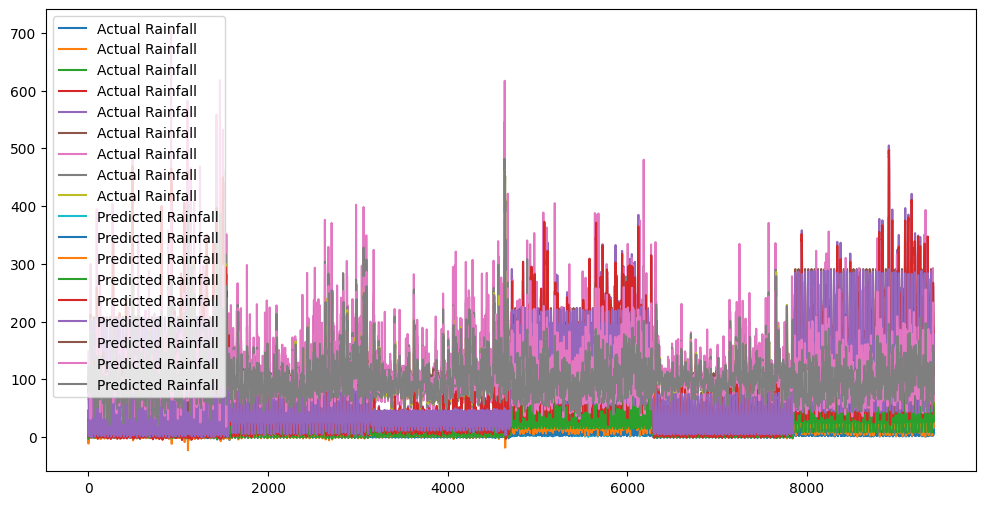

In [18]:
# Inverse transform predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Rainfall')
plt.plot(y_pred_inv, label='Predicted Rainfall')
plt.legend()
plt.show()

**Prediction of one sample**

In [19]:
# Select a row from X_test to create a single input data point
single_input_data = X_test[0]  # Selecting the first row as an example
print(single_input_data)
# Reshape the single input data point to match the model's input shape
single_input_data_reshaped = single_input_data.reshape(1, single_input_data.shape[0], single_input_data.shape[1])

# Print the shape of the reshaped input data
print("Shape of the reshaped input data:", single_input_data_reshaped.shape)


[[0.02406074 0.11186634 0.21042301 0.19751724 0.31503643 0.32891127
  0.07272544 0.37783662 0.30239915]
 [0.0192425  0.09141326 0.06504041 0.14587357 0.26091566 0.29200555
  0.07416745 0.15925419 0.27980015]
 [0.01078053 0.072451   0.0232774  0.09564869 0.24717656 0.27179644
  0.06457205 0.09805455 0.28459684]
 [0.04869351 0.09753981 0.03392974 0.09066583 0.21915691 0.25114825
  0.13971259 0.13841713 0.2716919 ]
 [0.04122532 0.10443545 0.04343611 0.09519537 0.21095672 0.22861015
  0.11578413 0.16307329 0.28753683]
 [0.06113021 0.21048828 0.06520977 0.14320538 0.17599796 0.21665892
  0.08737141 0.16245478 0.25065382]
 [0.11662951 0.37287235 0.09458841 0.23896799 0.19953075 0.23346716
  0.09202871 0.14054053 0.26516723]
 [0.10479496 0.48198701 0.12207867 0.37028345 0.13514431 0.27141779
  0.0616428  0.11423829 0.14675685]
 [0.42288379 0.55116169 0.27851746 0.48877208 0.21620173 0.32382404
  0.23522559 0.2062268  0.20398885]
 [0.00127005 0.00255555 0.05064598 0.10469045 0.08825197 0.13731

In [20]:
# Make a prediction
predicted_value = model.predict(single_input_data_reshaped)

# predict first value
predicted_rfh = predicted_value[0][0]

# Print the predicted 'rfh' value
print("Predicted 'rfh' value:", predicted_rfh)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted 'rfh' value: 0.025670288
